# Latency Comparison

In this section we collect results from measuring the latency between ingesting data from the source and collecting the data from the broker (i.e., Kafka vs NGSI-LD Broker).

First, execute the tests from Apache NiFi for each number of events to be sent to the broker every second. The results from these tests will be stored in `results/latency/<broker>/`.

## Building the Datasets

In [70]:
import pandas as pd

#Disable scientific notation in datasets
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Scorpio

Set list with number events per second configured for each experiment.

In [98]:
events = [50,60]

In [99]:
import glob

scorpio = []
for event in events:
    path = r'./results/latency/scorpio/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    scorpio.append(pd.concat(li, axis=0, ignore_index=True))
    
# Estimate the delta between the collection and notification timestamps
scorpio_means = []
for table in scorpio:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    scorpio_means.append(table["deltaTimestamp"].mean())

### Kafka

In [100]:
import glob

kafka = []
for event in events:
    path = r'./results/latency/kafka/%s' % event # use your path
    all_files = glob.glob(path + "/*")

    li = []

    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    kafka.append(pd.concat(li, axis=0, ignore_index=True))

# Estimate the delta between the collection and notification timestamps
kafka_means = []
for table in kafka:
    table["deltaTimestamp"] = table["notificationTimestamp"] - table["collectionTimestamp"]
    kafka_means.append(table["deltaTimestamp"].mean())

## Visualization

Once the datasets haven prepared, move on to creating some plots.

In [101]:
import matplotlib.pyplot as plt
plt.close("all")

<AxesSubplot:xlabel='Events'>

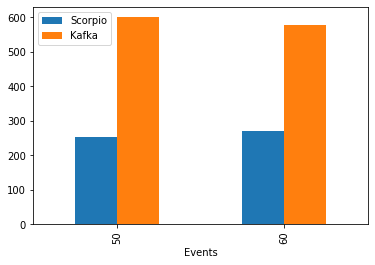

In [102]:
latency = pd.DataFrame({"Events": events,"Scorpio": scorpio_means, 
                        "Kafka": kafka_means })
latency.plot.bar(x="Events")

# Container Performance

The following snippet produces docker stats and appends the results to a CSV file. For these validation tests, we collect the memory and CPU percentage usage:

```bash
while true; do docker stats <my_container> --no-stream --format "{{ .CPUPerc }},{{ .MemPerc }}" | tee --append results/cpu_memory/<my_container>/<my_container>_<events>.csv; sleep 1; done
```

We collect results for each NGSI-LD Broker and for Kafka while running the latency tests. Make sure to specify the `events` value used for the latency tests.

You can also use the `collect_docker_stats.sh` utility. The following example collects CPU and memory percentage usage stats for kafka when 60 events are sent every second:

```bash
./collect_docker_stats.sh kafka 60
```

## Building the Datasets

Process the generated CSV files using panda. First remove the percentage character from the memory and CPU columns. Then generate two charts - memory and CPU - that compare Kafka container against each NGSI-LD Broker container.

### Scorpio

In [103]:
scorpio_cpu = []
scorpio_memory = []
for event in events:
    dataset_path = r'./results/cpu_memory/scorpio/scorpio_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=None, 
                        header=0, names=["cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    scorpio_cpu.append(table['cpu'].mean())
    scorpio_memory.append(table['memory'].mean())

### Kafka

In [106]:
kafka_cpu = []
kafka_memory = []
for event in events:
    dataset_path = r'./results/cpu_memory/kafka/kafka_%s.csv' % event # use your path    
    table = pd.read_csv(dataset_path, index_col=None, 
                        header=None, names=["cpu", "memory"])
    table['cpu'] = table['cpu'].str.rstrip('%').astype('float') / 100.0
    table['memory'] = table['memory'].str.rstrip('%').astype('float') / 100.0
    kafka_cpu.append(table['cpu'].mean())
    kafka_memory.append(table['memory'].mean())

## Visualization

### CPU Performance

<AxesSubplot:xlabel='Events'>

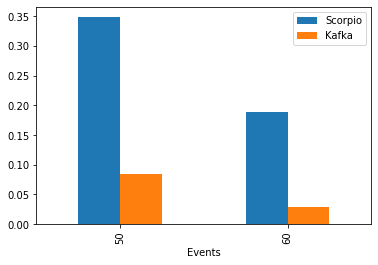

In [108]:
cpu_perf = pd.DataFrame({"Events": events,"Scorpio": scorpio_cpu, "Kafka": kafka_cpu})
cpu_perf.plot.bar(x="Events")

### Memory Performance

<AxesSubplot:xlabel='Events'>

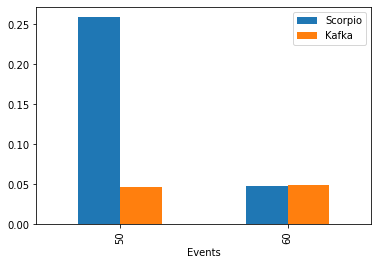

In [109]:
memory_perf = pd.DataFrame({"Events": events,"Scorpio": scorpio_memory, "Kafka": kafka_memory})
memory_perf.plot.bar(x="Events")